In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as mdates


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option('display.max_columns', None)

## Load Data 

In [2]:
df = pd.read_csv("transaction.csv", parse_dates=["transactionDateTime", "currentExpDate", "accountOpenDate", "dateOfLastAddressChange"])


## Preprocess

In [151]:
df.shape


(786363, 29)

In [38]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percentage_missing': percent_missing})
missing_value_df.sort_values('percentage_missing', inplace=True)
missing_value_df.round(2)

,percentage_missing
accountNumber,0.00
cardPresent,0.00
currentBalance,0.00
cardLast4Digits,0.00
enteredCVV,0.00
cardCVV,0.00
expirationDateKeyInMatch,0.00
accountOpenDate,0.00
currentExpDate,0.00
merchantCategoryCode,0.00


In [39]:
df = df.drop(columns= ["merchantCity", "echoBuffer", "merchantState", "merchantZip", "posOnPremises", "recurringAuthInd" ])

In [40]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,2.0,1.0,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,9.0,1.0,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,9.0,1.0,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,9.0,1.0,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,2.0,1.0,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [116]:
cat_feature = ["merchantName",
               "acqCountry",
               "merchantCountryCode",
               "posEntryMode",
               "posConditionCode",
               "merchantCategoryCode",
               "transactionType",
               "cardPresent",
               "expirationDateKeyInMatch"
               ]


print(df[cat_feature].nunique())



merchantName                2490
acqCountry                     4
merchantCountryCode            4
posEntryMode                   5
posConditionCode               3
merchantCategoryCode          19
transactionType                3
cardPresent                    2
expirationDateKeyInMatch       2
dtype: int64


## Separate target

In [50]:
df_y = df['isFraud']
df_y.value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [49]:
df_y.value_counts(normalize=True)

False    0.98421
True     0.01579
Name: isFraud, dtype: float64

## Check cardCVV and enteredCVV

In [51]:
df_cvv_match = df[["cardCVV", "enteredCVV","isFraud" ]]
df_cvv_match["match"] = (df['cardCVV']==df['enteredCVV']).astype(int)
df_cvv_match.drop(columns = ["cardCVV", "enteredCVV"], inplace = True)

C:\Users\60434\AppData\Local\Temp/ipykernel_22136/3443313356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cvv_match["match"] = (df['cardCVV']==df['enteredCVV']).astype(int)
D:\apps\Anaconda\envs\DB\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
df_cvv_match_T = df_cvv_match.loc[df_cvv_match['isFraud'] == True]
df_cvv_match_T["count"] = 1
df_cvv_match_T["Percent"] = df_cvv_match_T["count"].apply(lambda x : x/12417)
df_cvv_match_T.groupby(["match"]).sum().reset_index()

C:\Users\60434\AppData\Local\Temp/ipykernel_22136/487955140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cvv_match_T["count"] = 1
C:\Users\60434\AppData\Local\Temp/ipykernel_22136/487955140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cvv_match_T["Percent"] = df_cvv_match_T["count"].apply(lambda x : x/12417)


,match,isFraud,count,Percent
0,0,203,203,0.016349
1,1,12214,12214,0.983651


In [60]:
df_cvv_match_F = df_cvv_match.loc[df_cvv_match['isFraud'] == False]
df_cvv_match_F["count"] = 1
df_cvv_match_F["Percent"] = df_cvv_match_F["count"].apply(lambda x : x/773946)
df_cvv_match_F.groupby(["match"]).sum().reset_index()

C:\Users\60434\AppData\Local\Temp/ipykernel_22136/1573719926.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cvv_match_F["count"] = 1
C:\Users\60434\AppData\Local\Temp/ipykernel_22136/1573719926.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cvv_match_F["Percent"] = df_cvv_match_F["count"].apply(lambda x : x/773946)


,match,isFraud,count,Percent
0,0,0,6812,0.008802
1,1,0,767134,0.991198


## Group by customer ID

In [207]:
df_customer = df[["customerId", "transactionAmount", "isFraud"]]

In [208]:
df_customer = df_customer.groupby("customerId").filter(lambda x: any(x['isFraud'] == True))
df_customer = df_customer.groupby("customerId").filter(lambda x: any(x['isFraud'] == False))


In [186]:
df_customer_transaction = df_customer.groupby(["customerId", "isFraud"]).mean()

In [282]:
len(df_customer_transaction["customerId"].unique())

2073

In [288]:
df_customer_transaction.reset_index(inplace = True)

In [289]:
index = []
for num in range(1,2074):
    index.append(num)
    index.append(num)
df_customer_transaction["id"] = index

In [290]:
df_customer_transaction

,index,customerId,isFraud,transactionAmount,id
0,0,100088067,False,104.302432,1
1,1,100088067,True,309.960000,1
2,2,100737756,False,171.651412,2
3,3,100737756,True,331.720000,2
4,4,101132326,False,162.707812,3
...,...,...,...,...,...
4141,4141,999086814,True,176.496000,2071
4142,4142,999257059,False,163.075000,2072
4143,4143,999257059,True,282.290000,2072
4144,4144,999258704,False,96.095287,2073


[Text(0.5, 0, 'customer ID'),
 Text(0, 0.5, 'transaction amount'),
 Text(0.5, 1.0, 'Average transaction amount for each customer')]

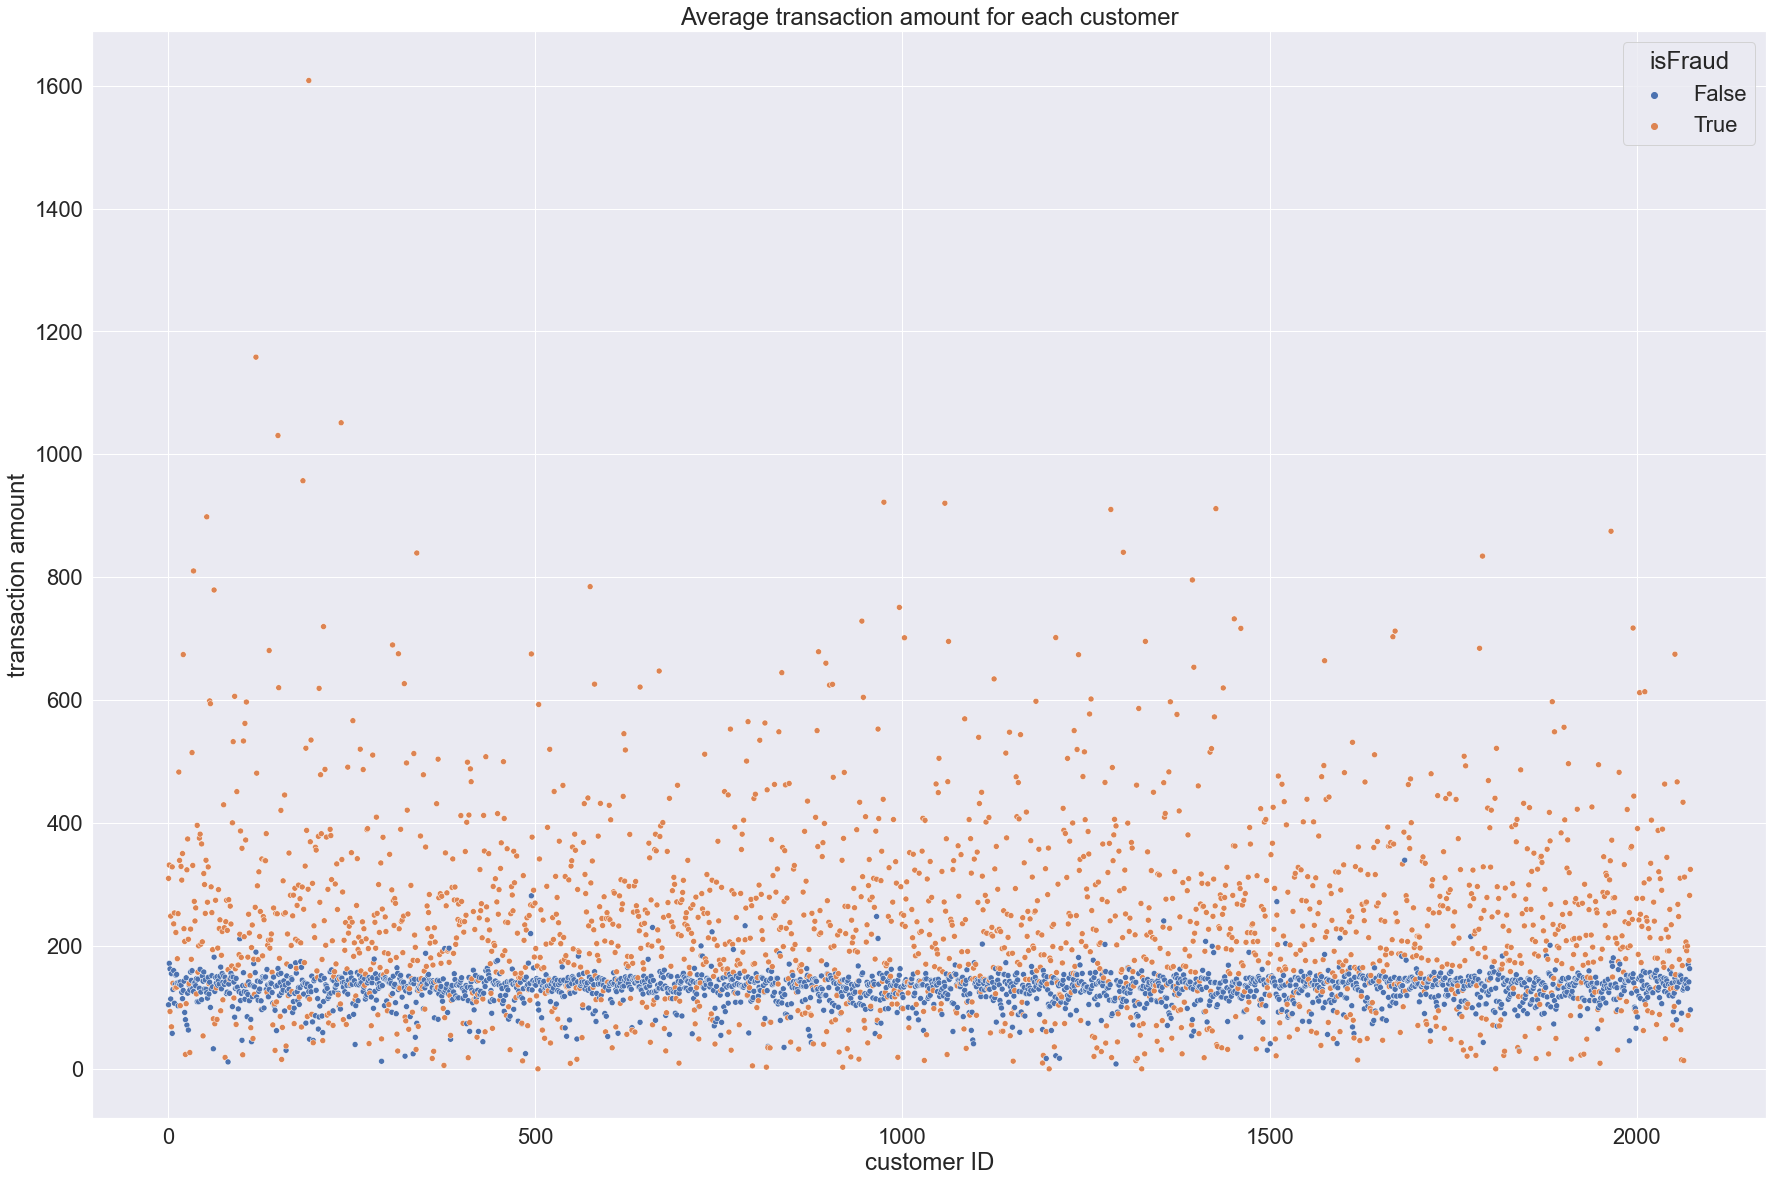

In [293]:
ax = sns.scatterplot(data = df_customer_transaction, x = "id", y = "transactionAmount", hue = "isFraud")
ax.set(xlabel = "customer ID", ylabel = "transaction amount", title = "Average transaction amount for each customer")

In [229]:
groups = dict(list(df_customer.groupby(["customerId"]) ))

In [250]:
id_list = list(groups.keys())

In [272]:
def get_customer(idx):
    df1  = df_customer.groupby(["customerId"]).get_group(id_list[idx])
    idx_list = []
    for num in range(1, len(df1)+1):
        idx_list.append(num)
    df1["id"] = idx_list
    return df1

C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["id"] = idx_list
C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["id"] = idx_list
C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["id"] = idx_list
C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["id"] = idx_list
C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

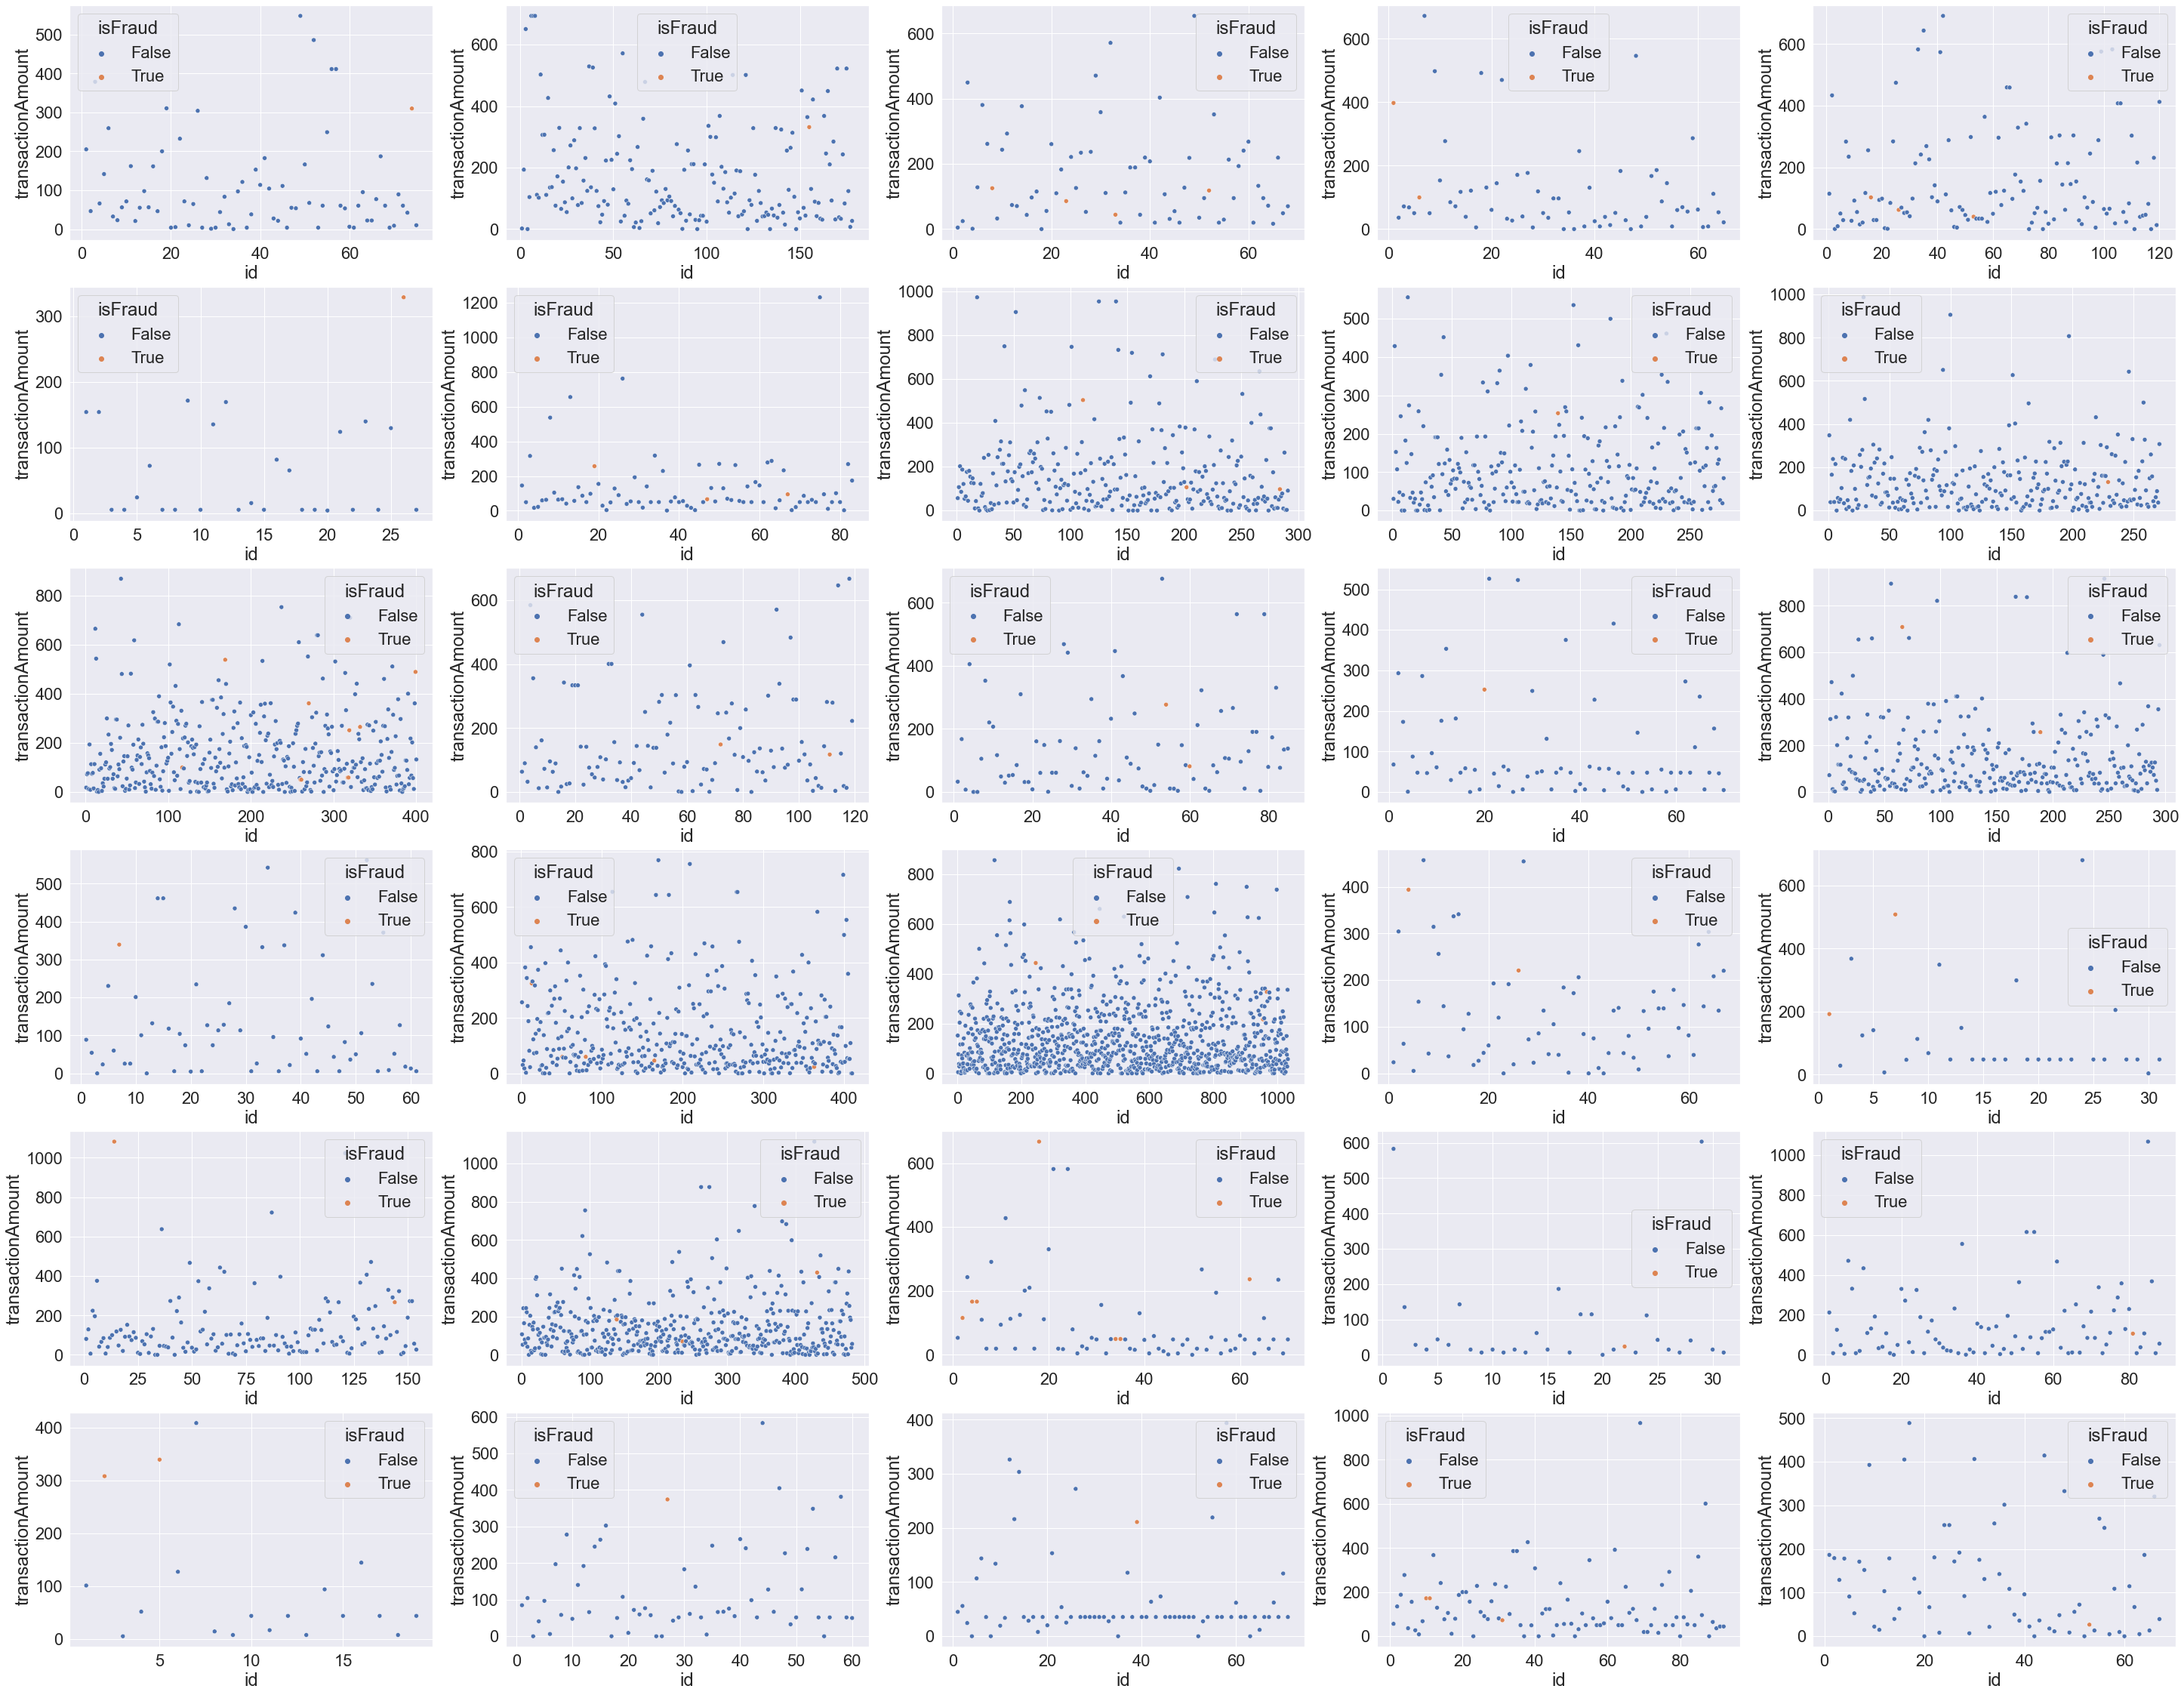

In [273]:
fig, ax = plt.subplots(6, 5, figsize = (50,40))

idx = 0
for subplot in ax.flatten():
    sns.scatterplot(x = "id", y = "transactionAmount", hue = "isFraud", data = get_customer(idx), ax=subplot)
    idx += 1
    

C:\Users\60434\AppData\Local\Temp/ipykernel_22136/761722405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["id"] = idx_list


<AxesSubplot:xlabel='id', ylabel='transactionAmount'>

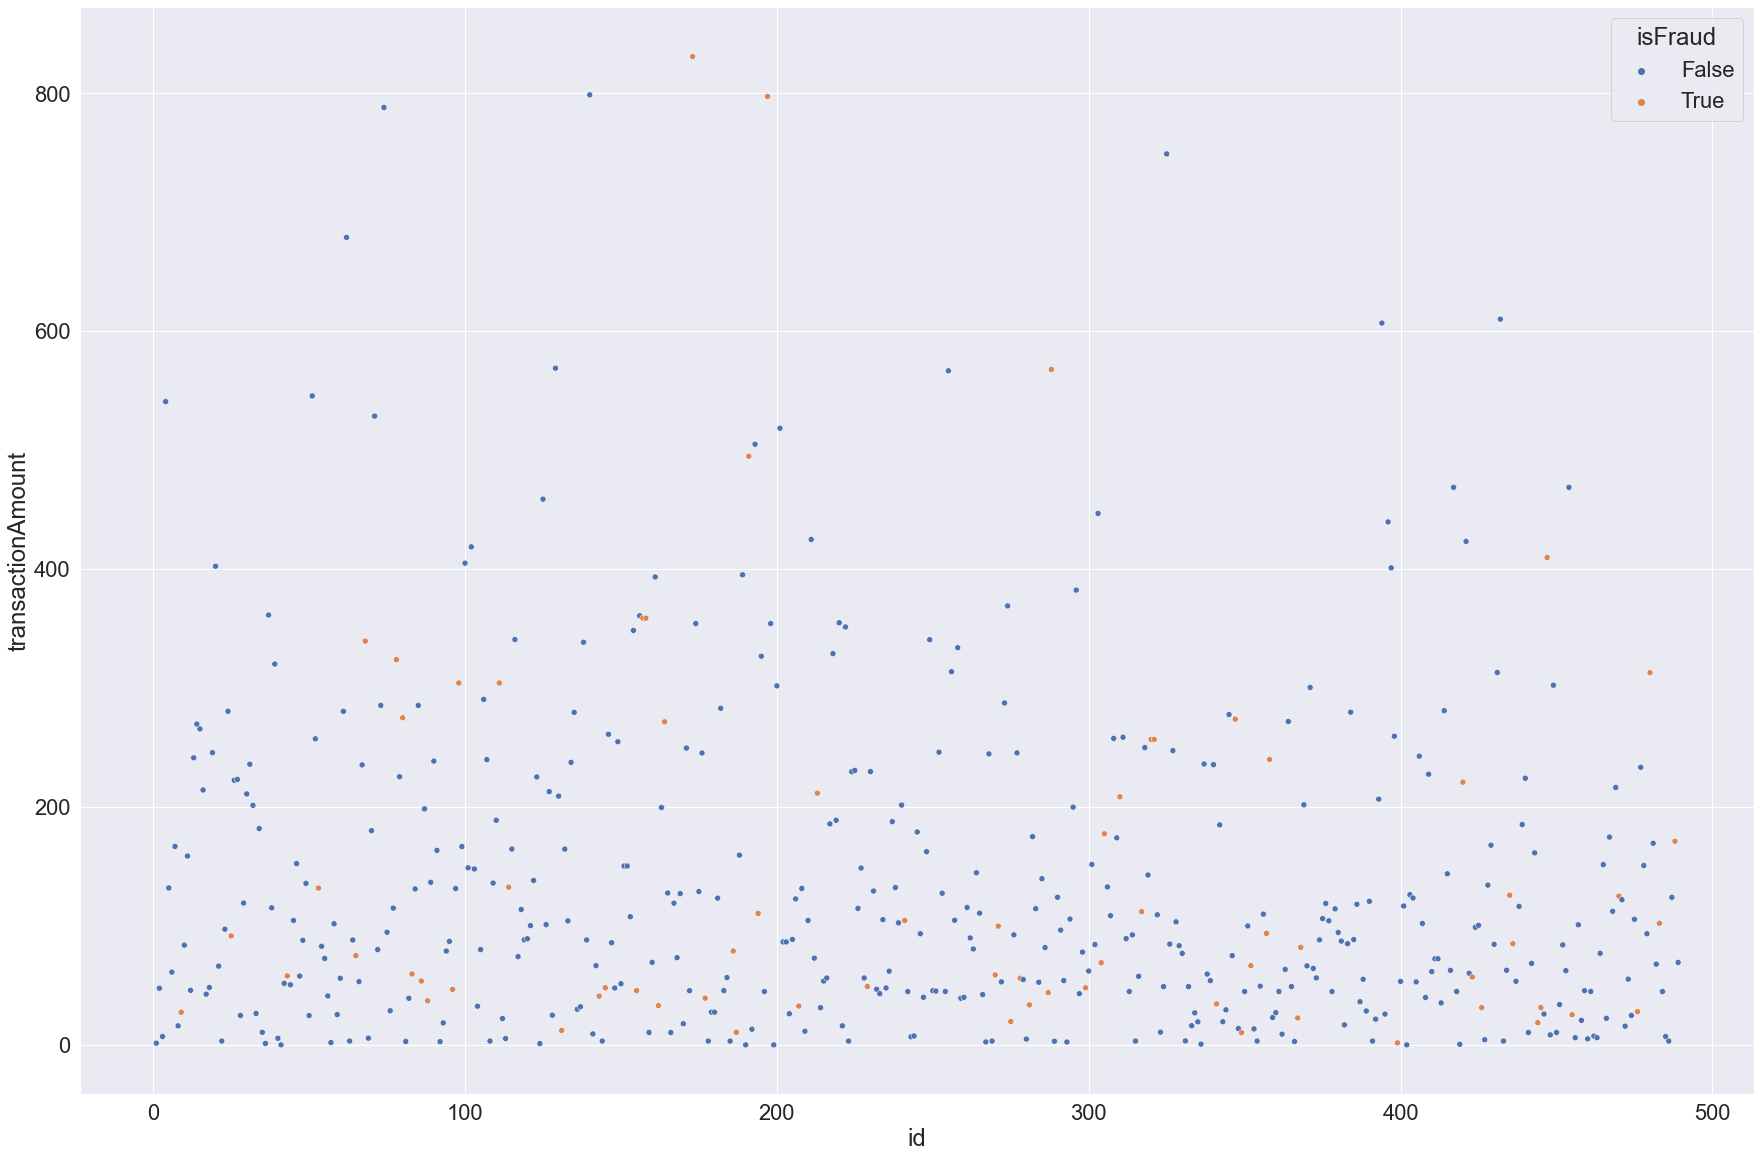

In [275]:
sns.scatterplot(x = "id", y ="transactionAmount", hue = "isFraud", data = get_customer(111))

## Get the fraud data

In [7]:
df_fraud = df.loc[df['isFraud'] == True]

In [21]:
date_feature = ["transactionDateTime", 
                "currentExpDate",
                "accountOpenDate",
                "dateOfLastAddressChange"
               ]

#### Analyze transactionDate 

In [3]:
import holidays

In [8]:
for date in holidays.UnitedStates(years=2016).items():
    print(date)
type(date[0])

(datetime.date(2016, 1, 1), "New Year's Day")
(datetime.date(2016, 1, 18), 'Martin Luther King Jr. Day')
(datetime.date(2016, 2, 15), "Washington's Birthday")
(datetime.date(2016, 5, 30), 'Memorial Day')
(datetime.date(2016, 7, 4), 'Independence Day')
(datetime.date(2016, 9, 5), 'Labor Day')
(datetime.date(2016, 10, 10), 'Columbus Day')
(datetime.date(2016, 11, 11), 'Veterans Day')
(datetime.date(2016, 11, 24), 'Thanksgiving')
(datetime.date(2016, 12, 25), 'Christmas Day')
(datetime.date(2016, 12, 26), 'Christmas Day (Observed)')


datetime.date

In [13]:
def map_day(val):
    if val == "0":
        return "Monday"
    elif val == "1":
        return "Tuesday"
    elif val == "2":
        return "Wednesday"
    elif val == "3":
        return "Thursday"
    elif val == "4":
        return "Friday"
    elif val == "5":
        return "Saturday"
    else:
        return "Sunday"

def plot_time(df, time_arg = "Date", time_name = "Date", column_name = "transactionDateTime"):
    df_time =  df[[column_name, "isFraud"]]
    if time_arg == "Date":
        df_time[time_name] = df_time[column_name].apply(lambda x: x.date())
    else:
        df_time[time_name] = df_time[column_name].dt.strftime(time_arg)
    
    df_time["Count"] = 1
    df_time = df_time.drop(columns = [column_name])
    
    df_time_T = df_time.loc[df_time['isFraud'] == True]
    df_time_F = df_time.loc[df_time['isFraud'] == False]
    
    df_time_T = df_time_T.groupby([time_name]).sum().reset_index()
    df_time_T["Percent"] = df_time_T["Count"].apply(lambda x : x/12417)
    df_time_F = df_time_F.groupby([time_name]).sum().reset_index()
    df_time_F["Percent"] = df_time_F["Count"].apply(lambda x : x/773946)

    df_time_to_plot = df_time_T.append(df_time_F, ignore_index = True)
    df_time_to_plot["isFraud"] = df_time_to_plot["isFraud"].apply(lambda x: True if (x > 0) else False)
    

    if time_arg == "%w":
        df_time_to_plot[time_name] = df_time_to_plot[time_name].apply(lambda x: map_day(x) )
    
    
    if time_arg == "%Y":
        if column_name == "accountOpenDate":
            df_time_to_plot.drop([16, 18], inplace=True)
        elif column_name == "dateOfLastAddressChange":
            df_time_to_plot.drop([16, 18, 19], inplace=True)
    
    sns.set(rc={'figure.figsize':(30,20)},font_scale=2)
    ax = sns.lineplot(x = time_name, y = "Percent", hue = "isFraud", data =df_time_to_plot)
    ax.set(title = "Percentage Frequency vs " + time_name + " for " + column_name)
    return df_time_to_plot


    

C:\Users\60434\AppData\Local\Temp/ipykernel_27264/1764550808.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time[time_name] = df_time[column_name].apply(lambda x: x.date())
C:\Users\60434\AppData\Local\Temp/ipykernel_27264/1764550808.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time["Count"] = 1


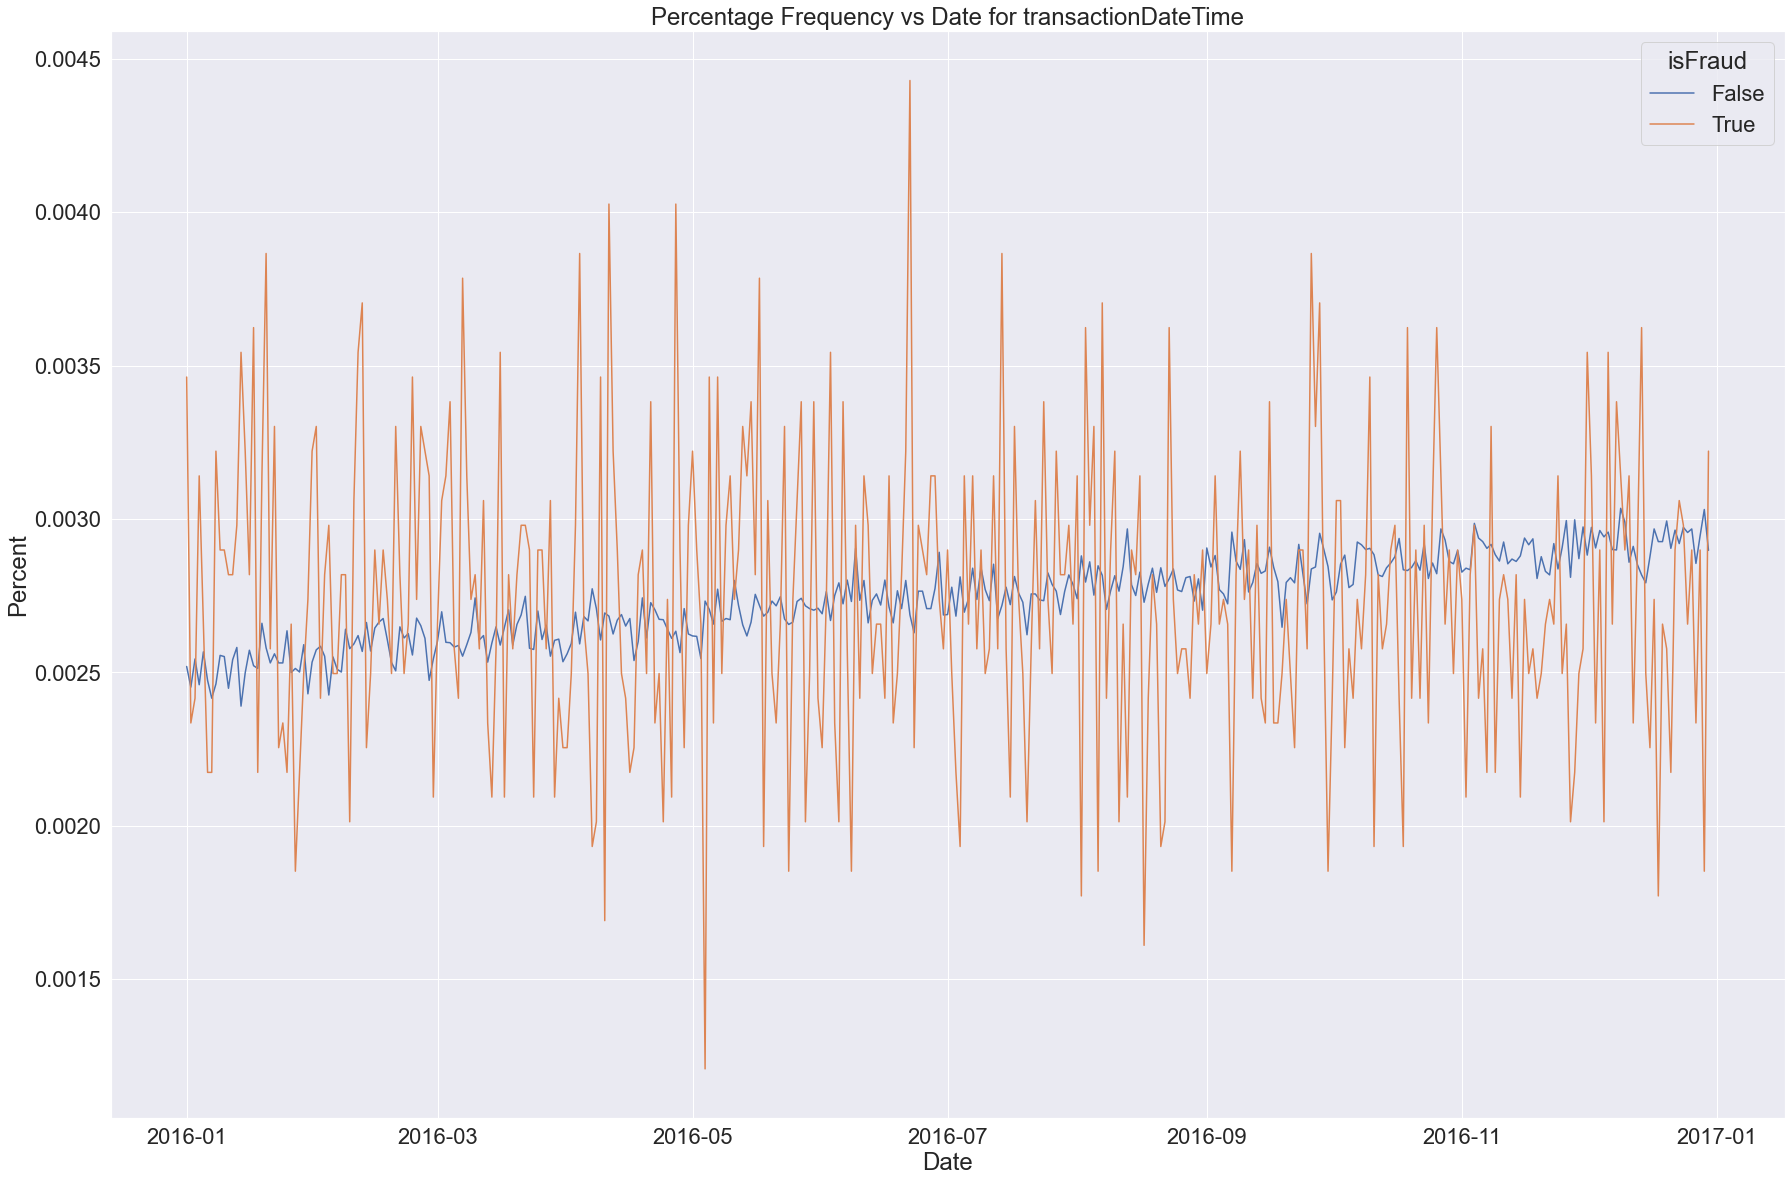

In [14]:
df_to_plot = plot_time(df, "Date", "Date")
# for date in holidays.UnitedStates(years=2016).items():
#     ax.annotate(date[1], (mdates.date2num(date[0]), 0.0015),  arrowprops=dict(arrowstyle='-|>'))

[Text(0.5, 1.0, 'histogram of percent frequency for fraud transaction grouped by date')]

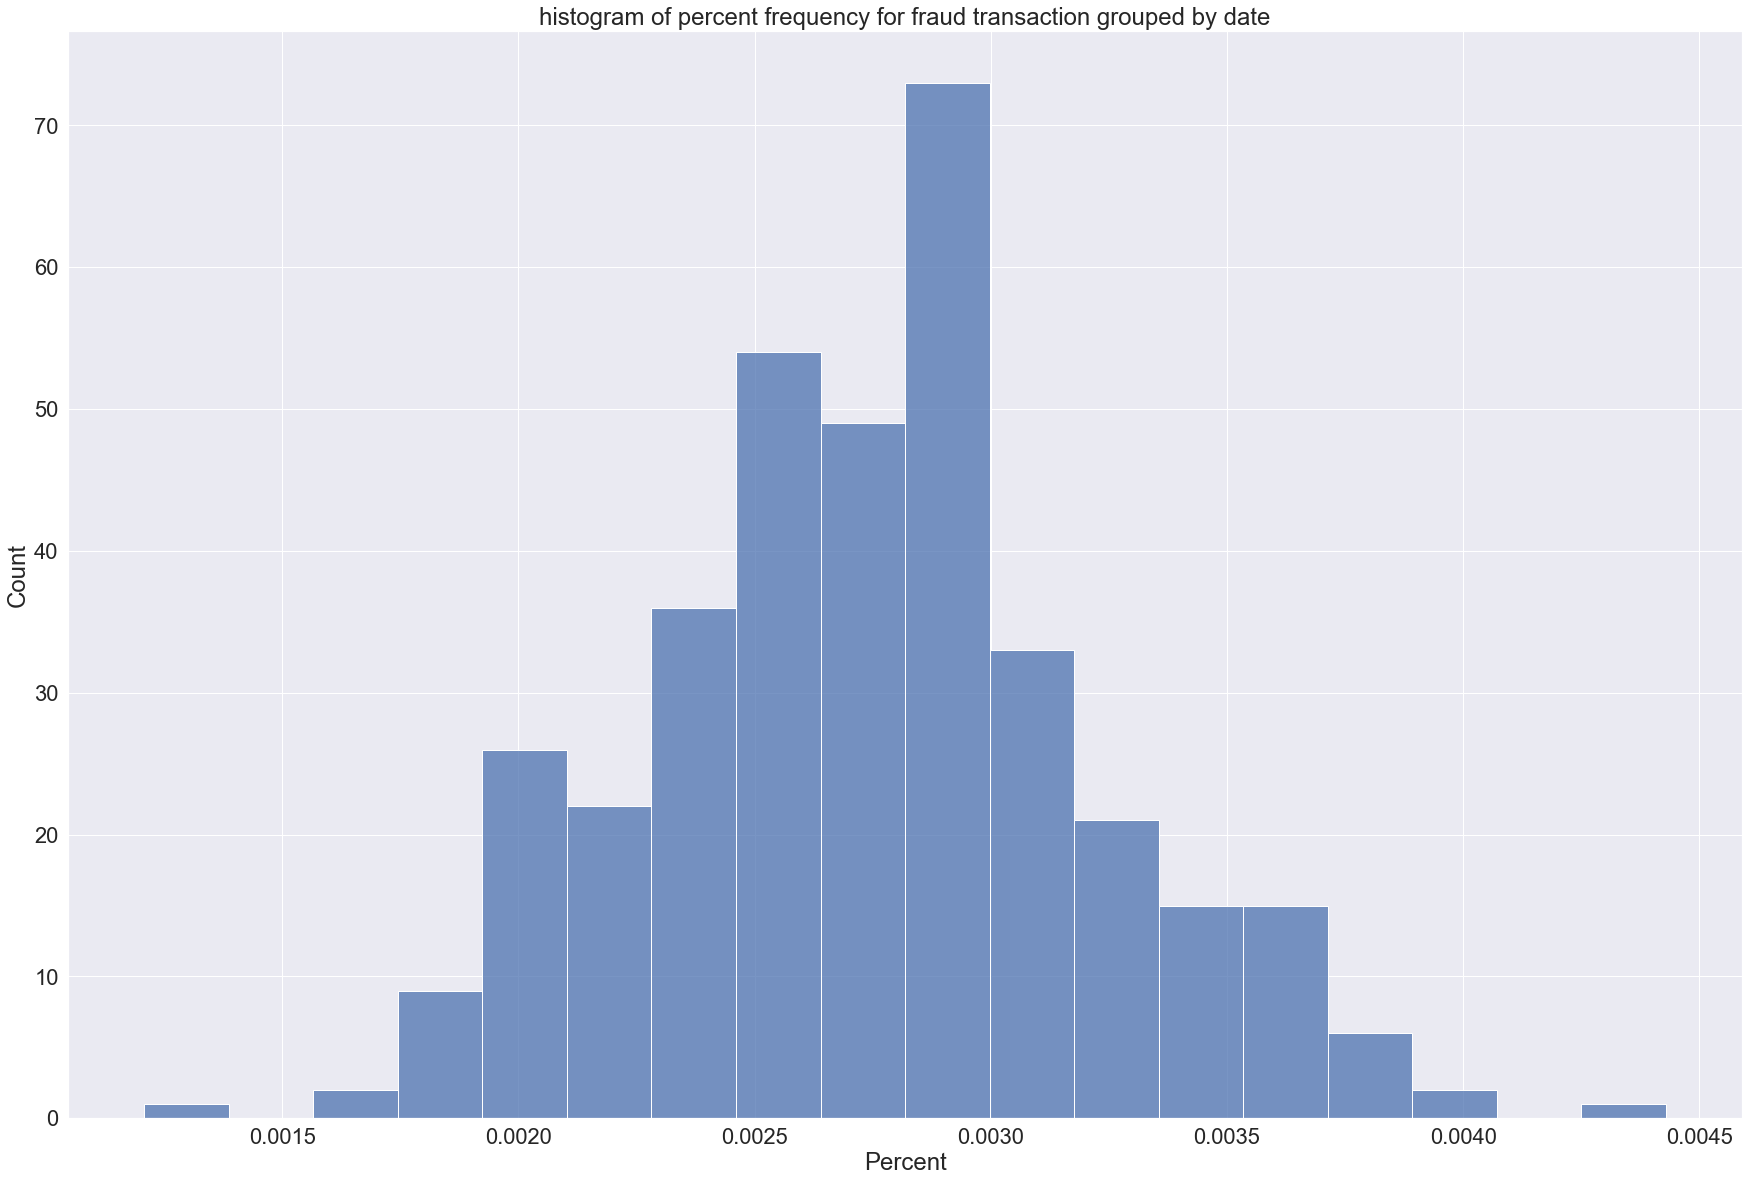

In [17]:
df_to_plot = df_to_plot.loc[df_to_plot["isFraud"] == True]
ax = sns.histplot(data = df_to_plot, x = "Percent")
ax.set(title = "histogram of percent frequency for fraud transaction grouped by date")

In [20]:
for date in holidays.UnitedStates(years=2016).items():
    ax.annotate(date[1], (mdates.date2num(date[0]), 0))
plt.show()

D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


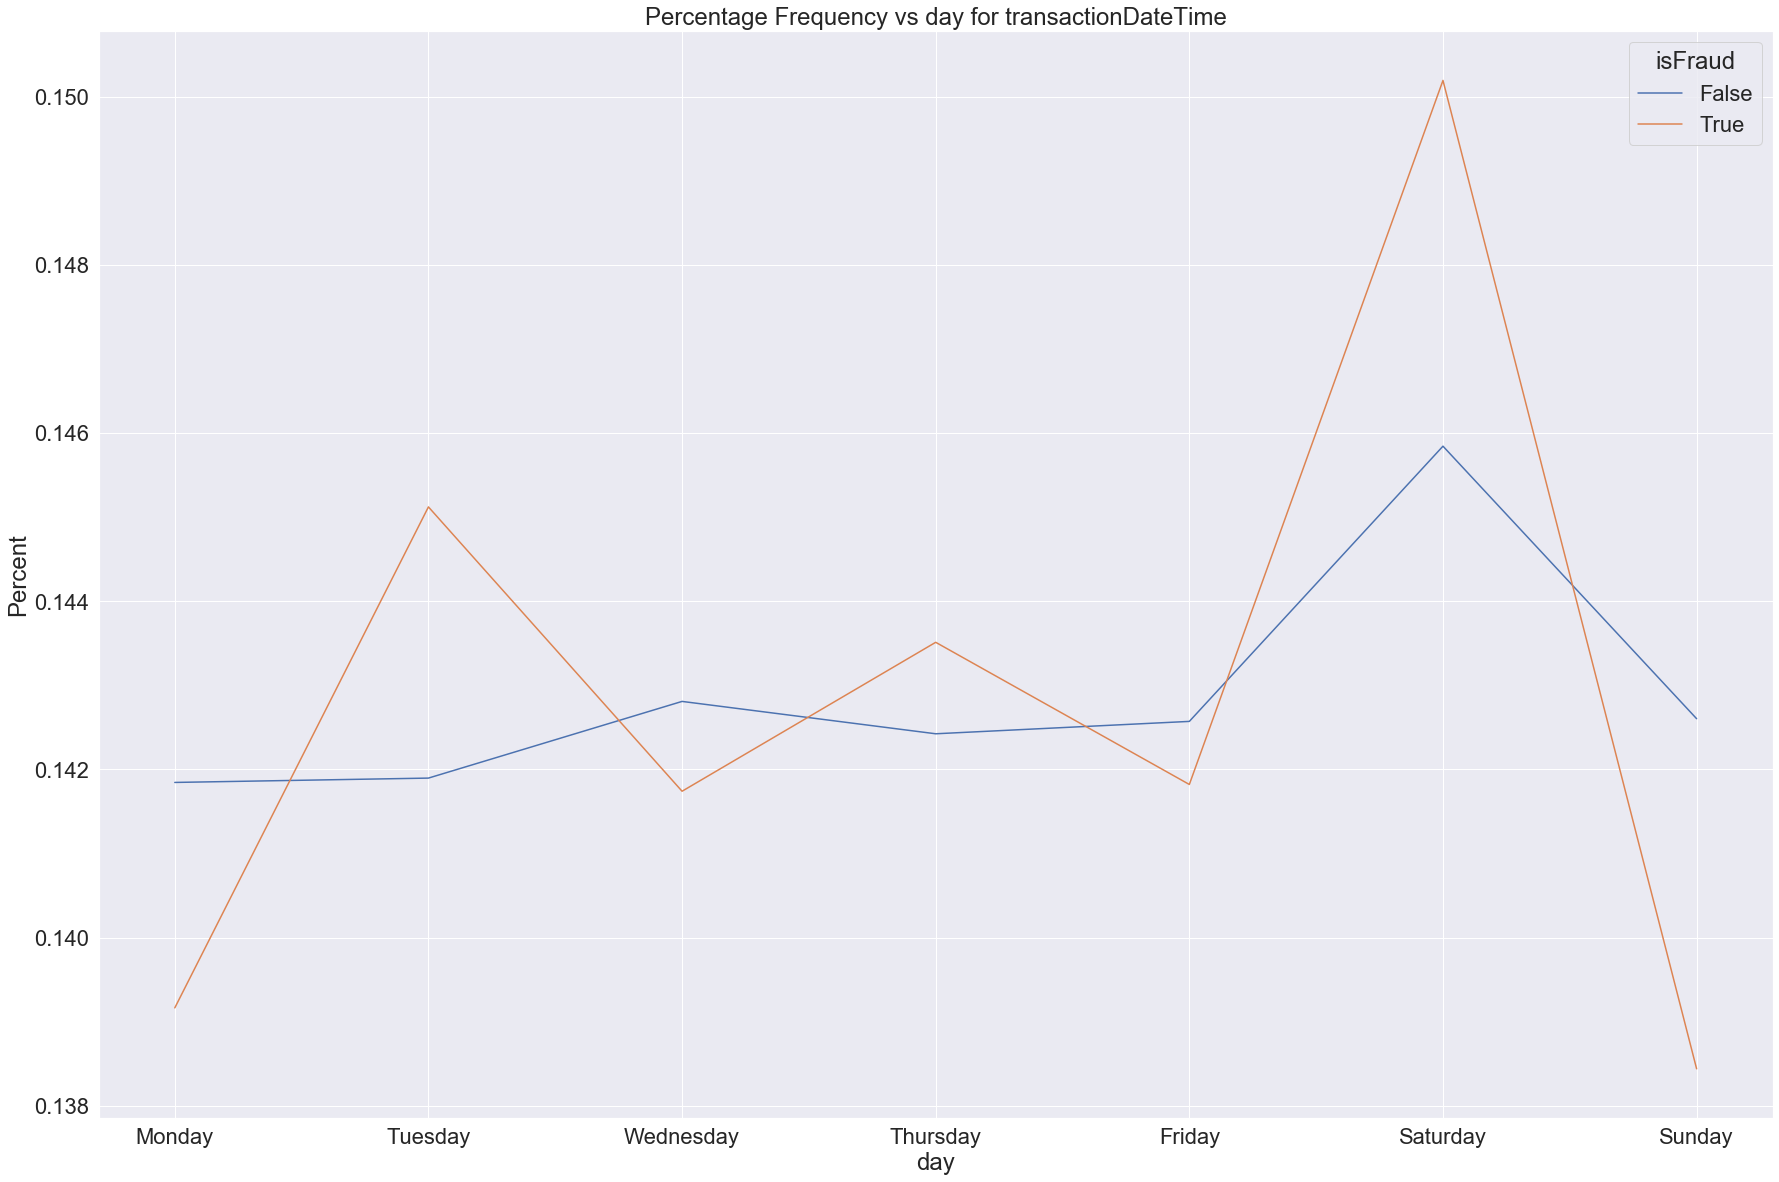

In [305]:
plot_time(df, "%w", "day")


D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


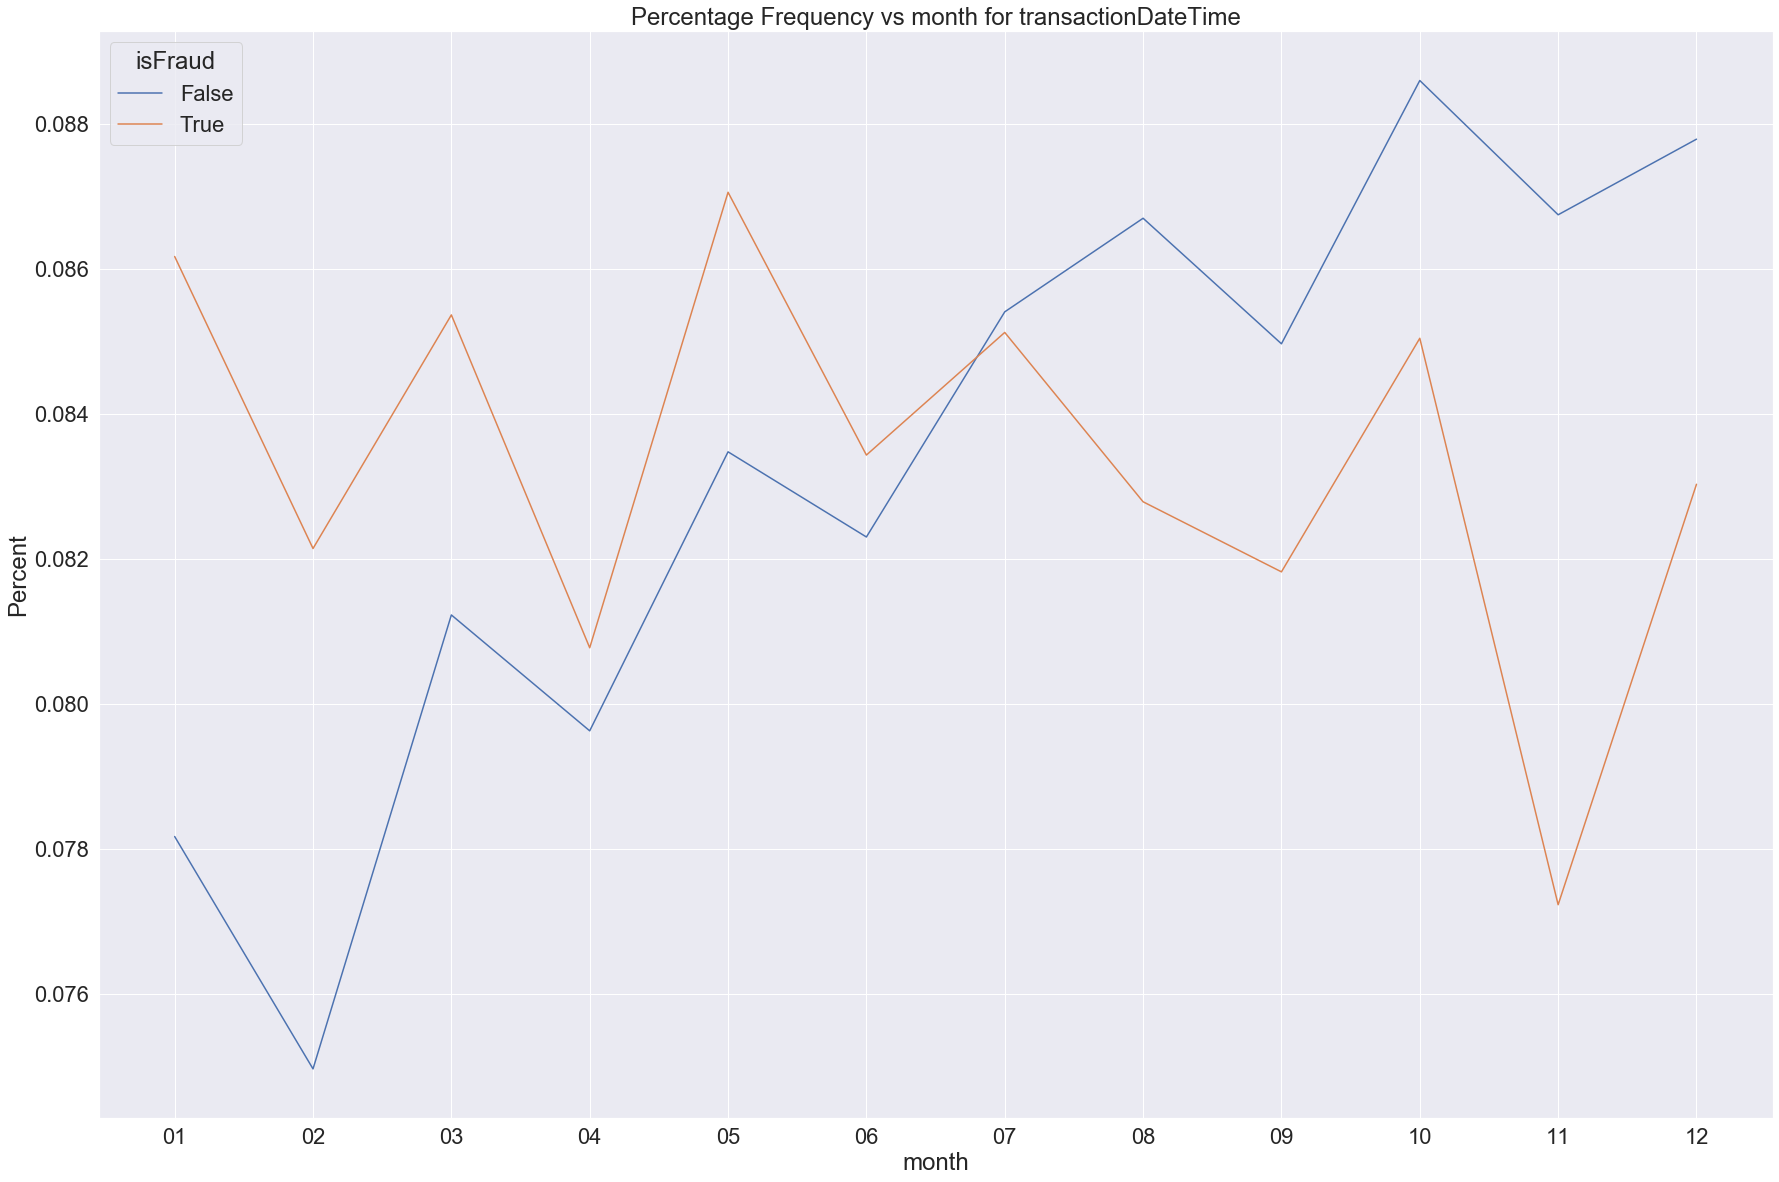

In [306]:
plot_time(df, "%m", "month")


D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


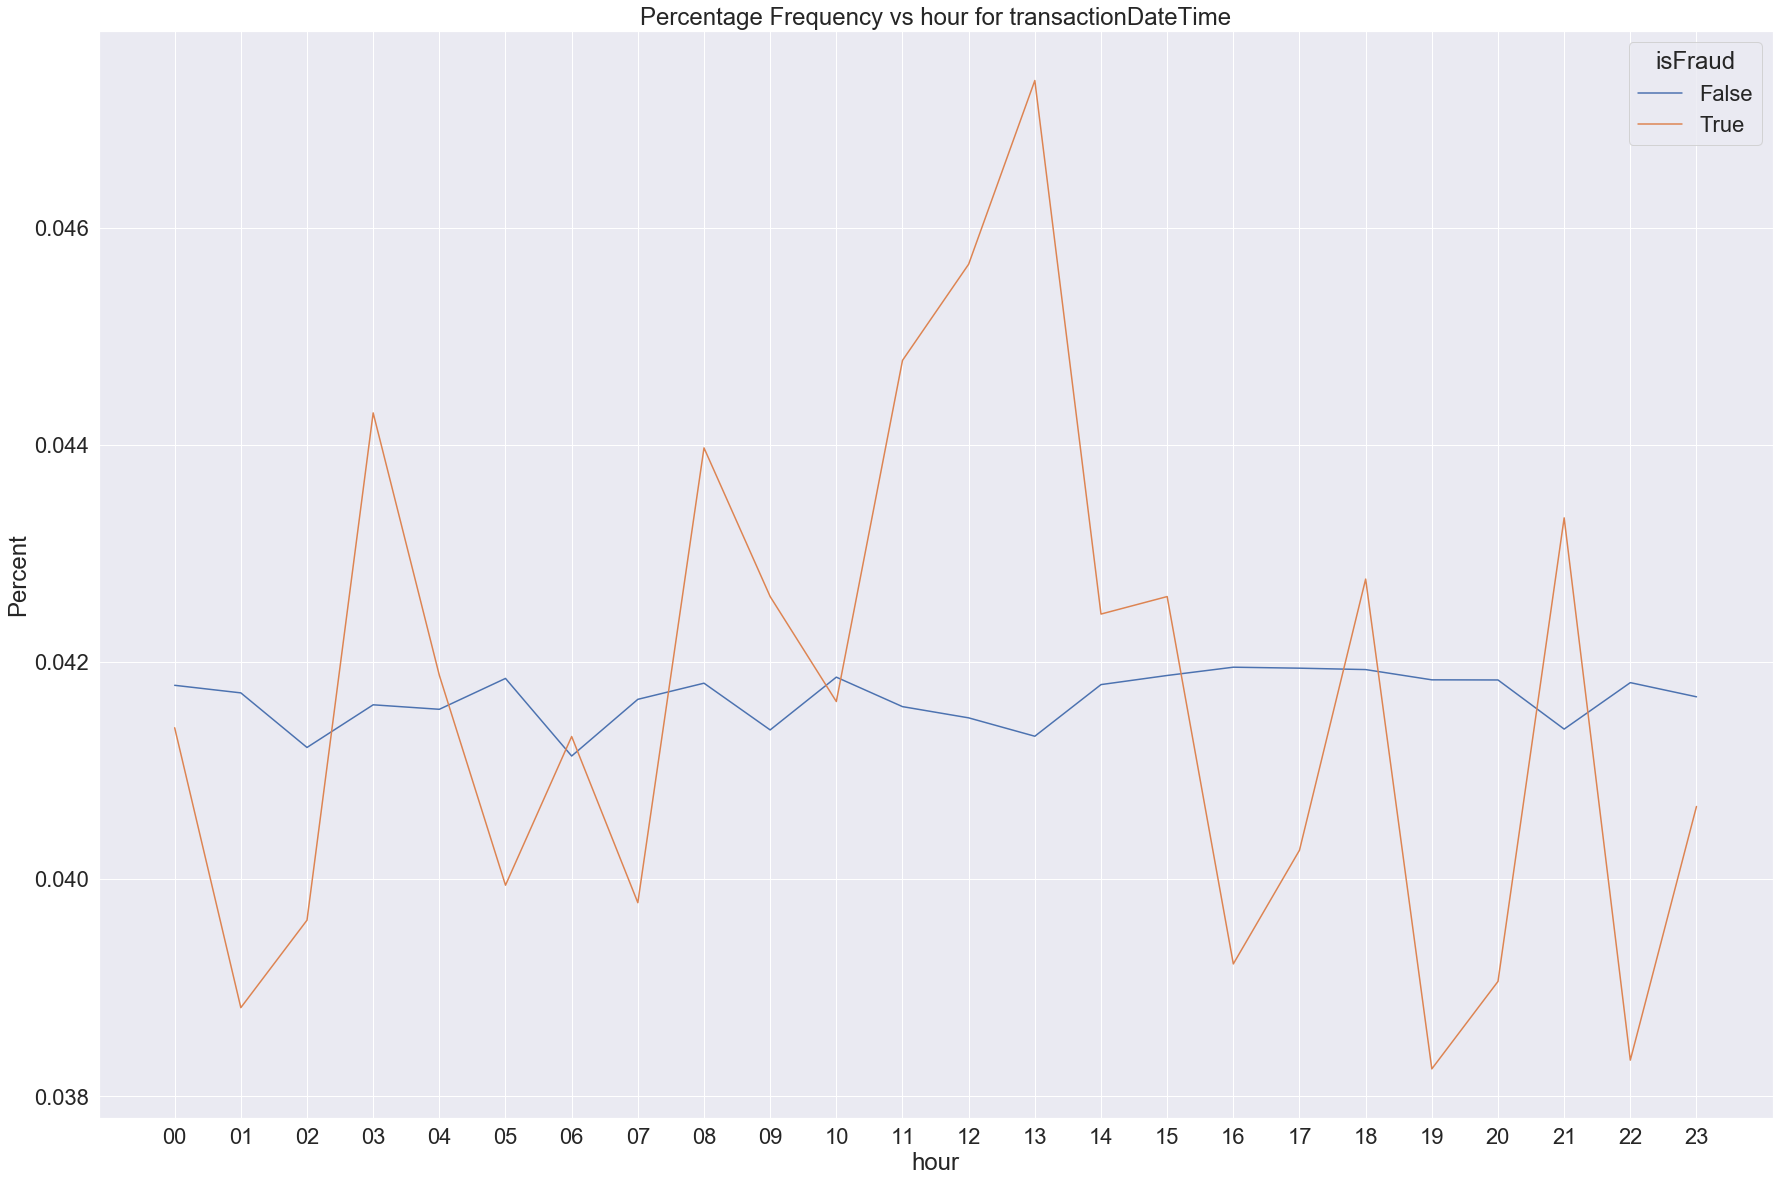

In [307]:
plot_time(df, "%H", "hour")

C:\Users\60434\AppData\Local\Temp/ipykernel_27264/3852712238.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time[time_name] = df_time[column_name].dt.strftime(time_arg)
C:\Users\60434\AppData\Local\Temp/ipykernel_27264/3852712238.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time["Count"] = 1


<AxesSubplot:title={'center':'Percentage Frequency vs Year for accountOpenDate'}, xlabel='Year', ylabel='Percent'>

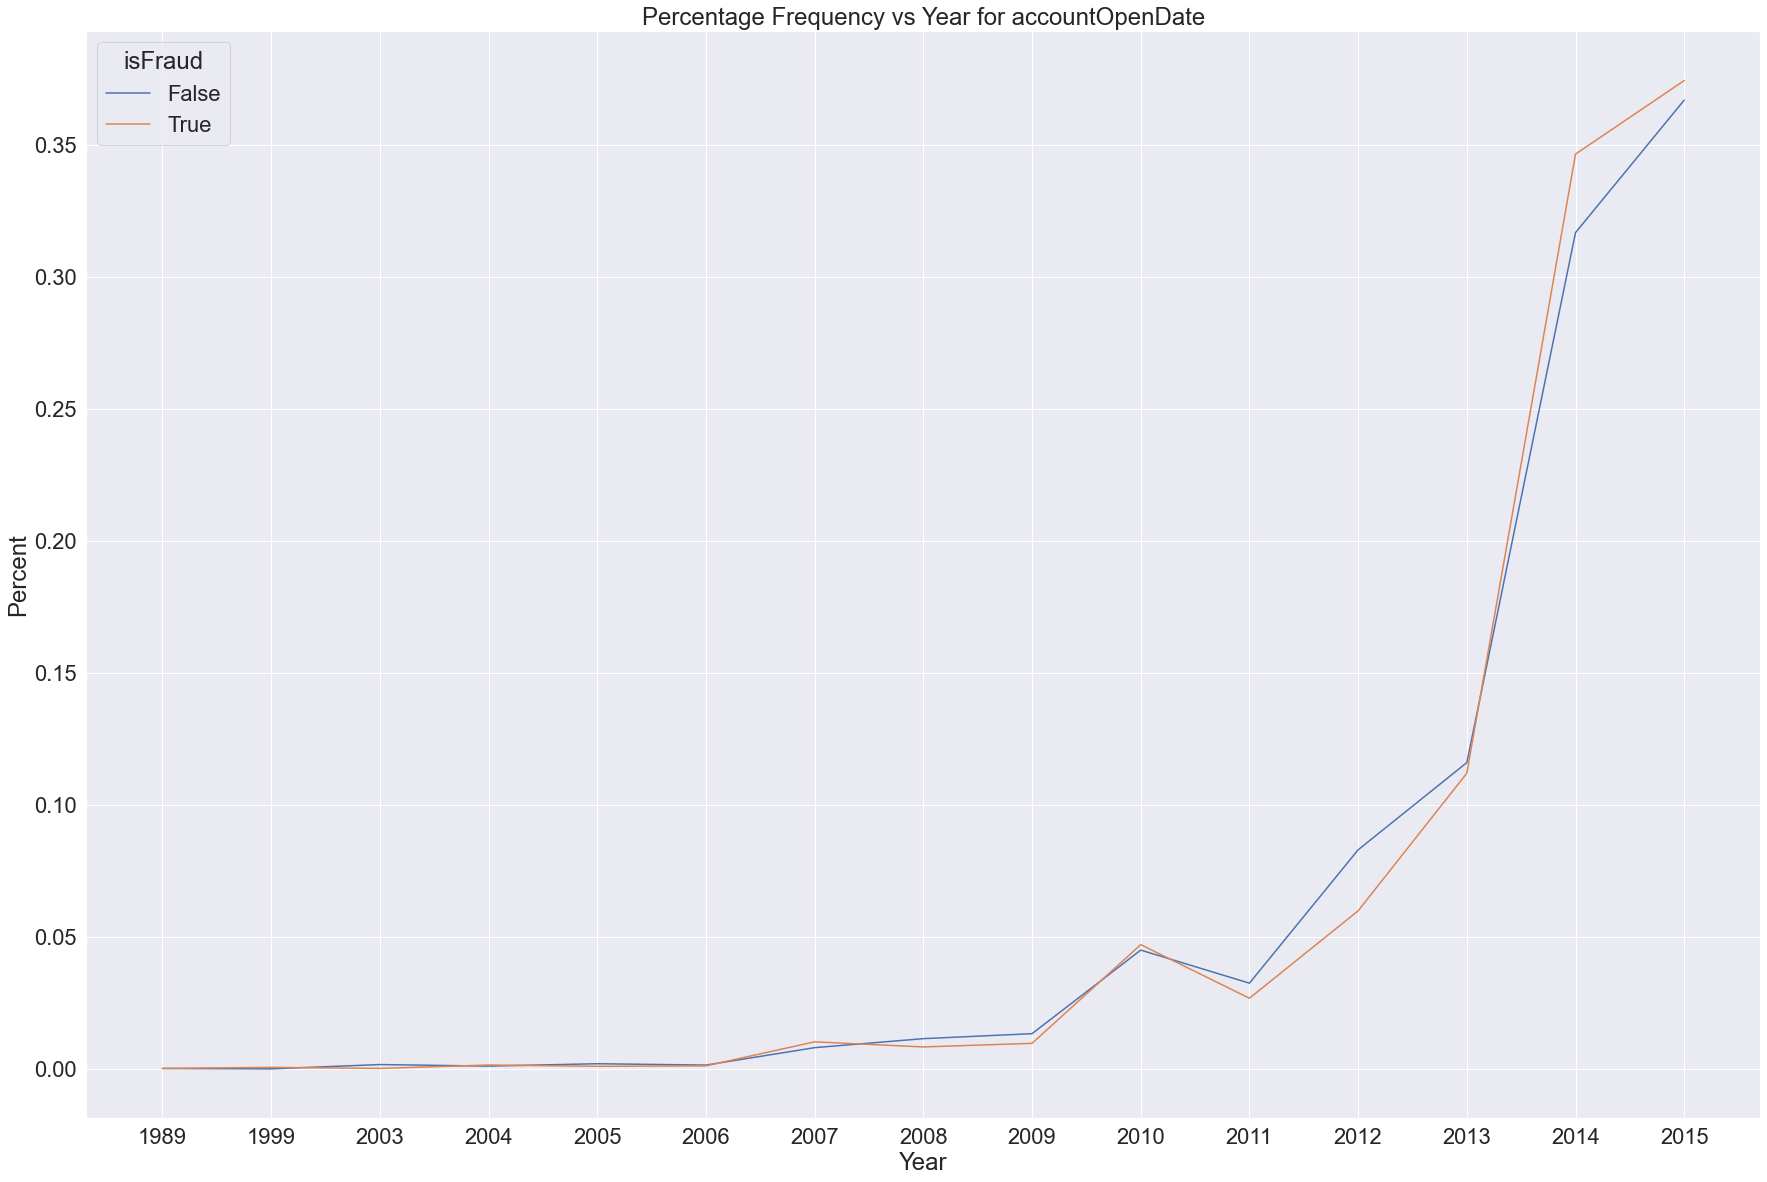

In [10]:
plot_time(df, "%Y" , "Year","accountOpenDate" )

C:\Users\60434\AppData\Local\Temp/ipykernel_27264/3852712238.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time[time_name] = df_time[column_name].dt.strftime(time_arg)
C:\Users\60434\AppData\Local\Temp/ipykernel_27264/3852712238.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time["Count"] = 1


<AxesSubplot:title={'center':'Percentage Frequency vs Year for dateOfLastAddressChange'}, xlabel='Year', ylabel='Percent'>

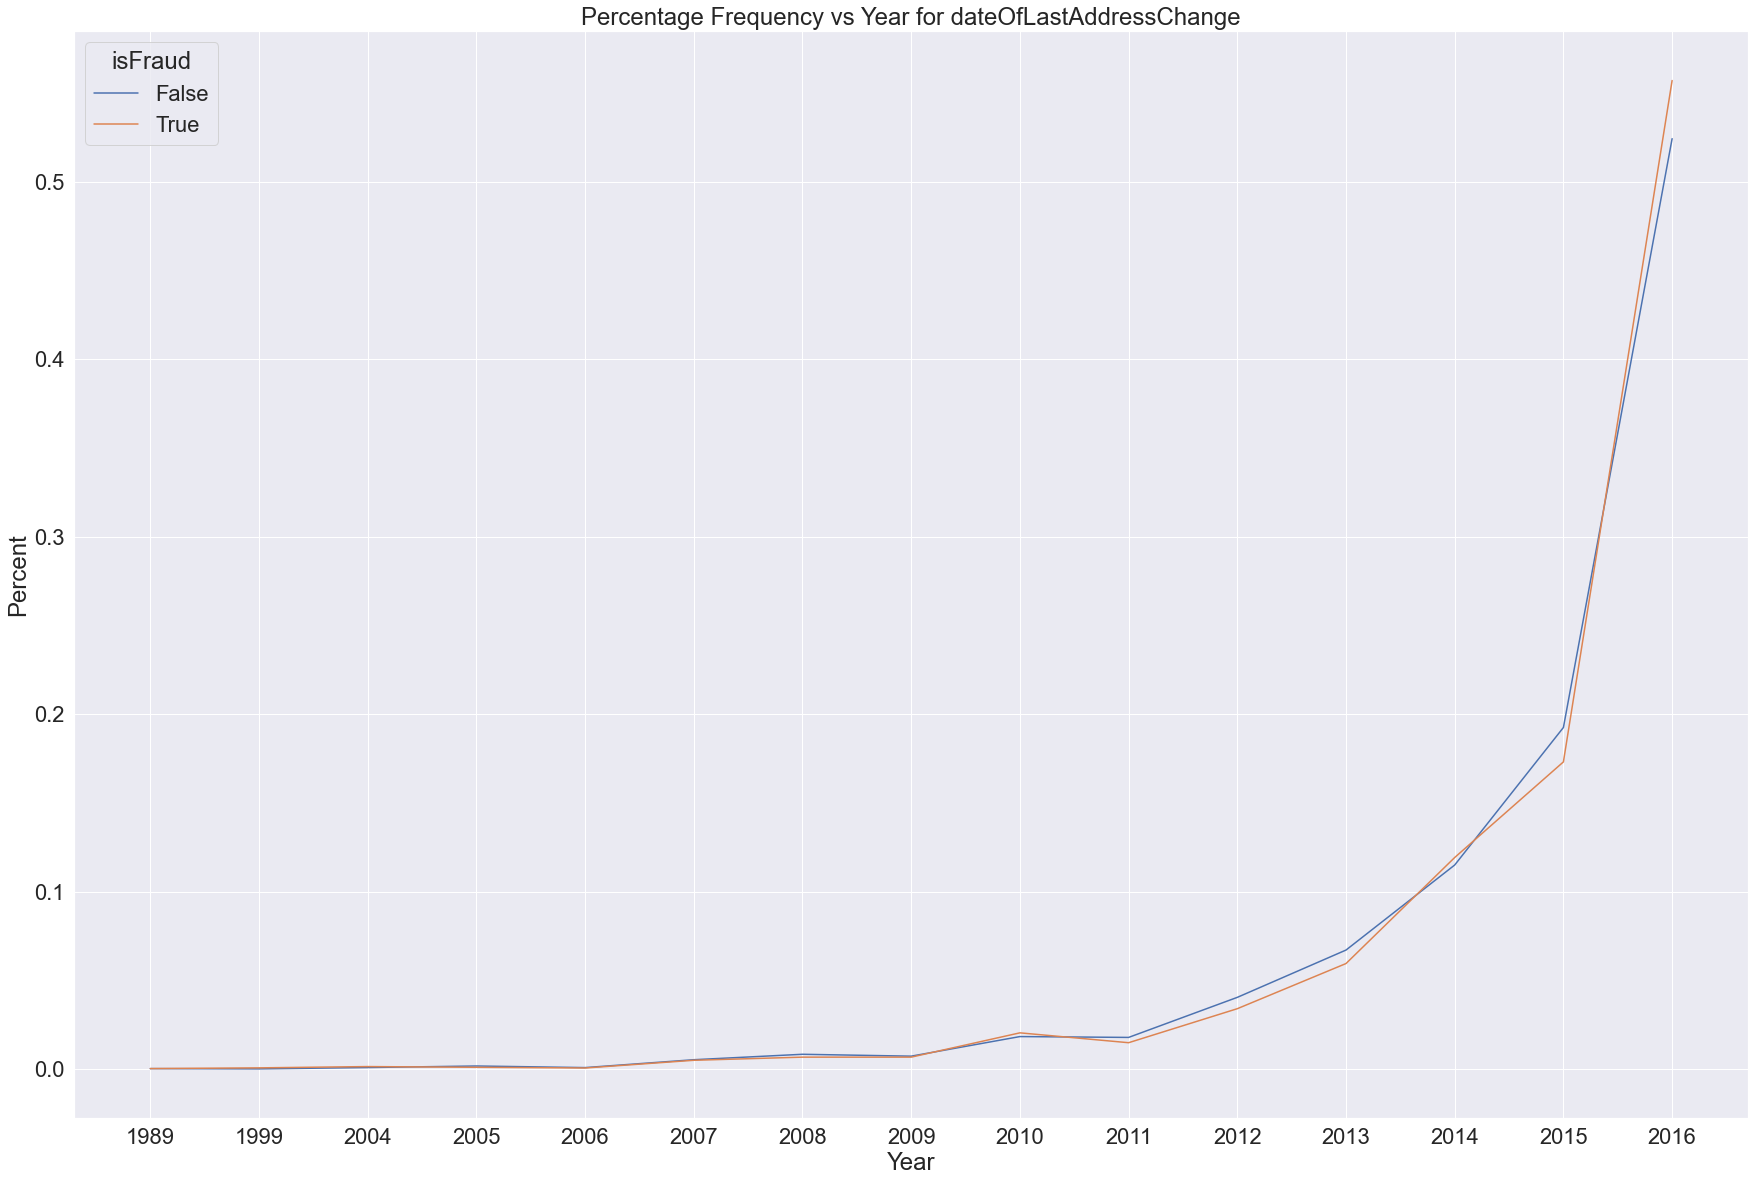

In [11]:
plot_time(df, "%Y" , "Year", "dateOfLastAddressChange" )

D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


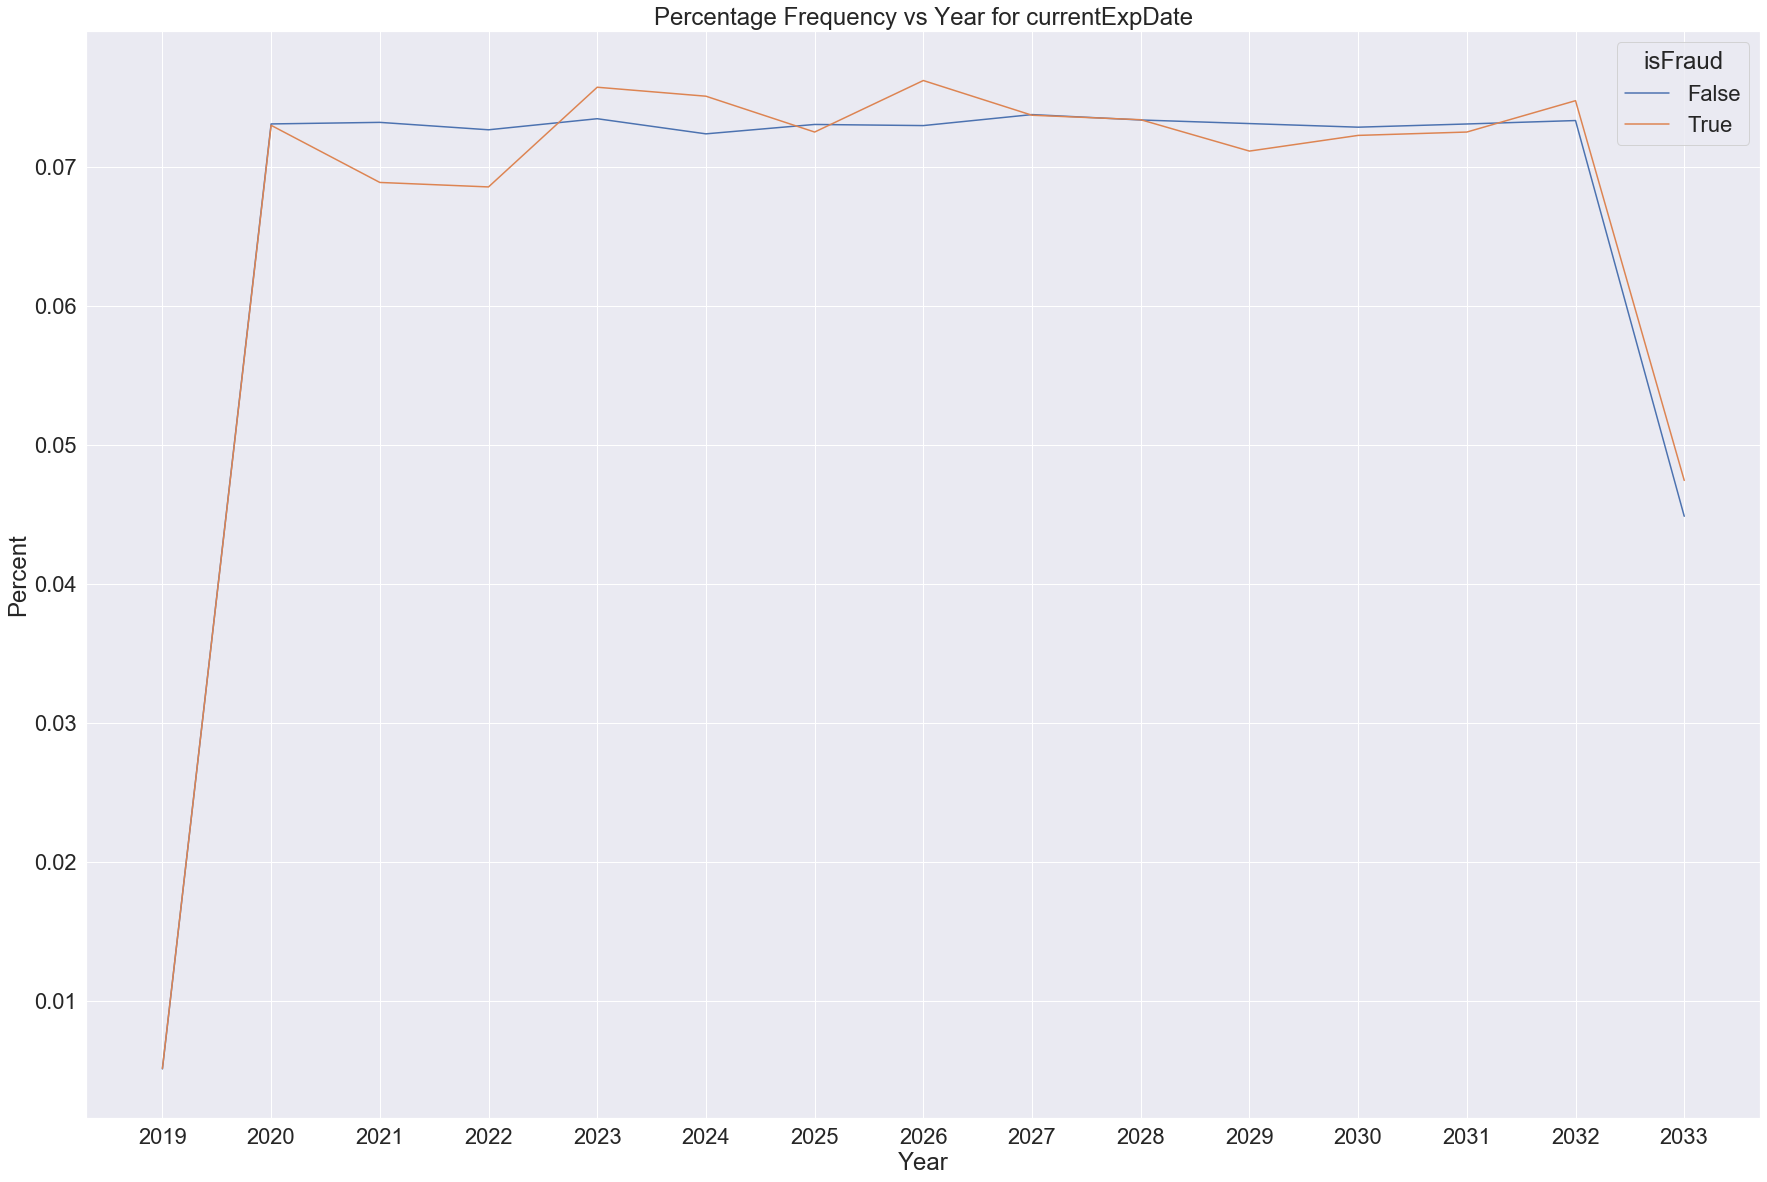

In [313]:
plot_time(df, "%Y" , "Year", "currentExpDate" )